# Monte Carlo simulation for project risk assessment

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the free [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to use of Python and the NumPy library for Monte Carlo simulation applied to a simple project risk problem. The [associated lecture slides](https://risk-engineering.org/monte-carlo-methods/) provide an introduction to the use of stochastic simulation methods.

## Problem statement

A construction project involves three tasks:

- Task 1 is likely to take three days (70% probability), but it might also be completed in
  two days (with 10% probability) or four days (20% probability)

- Task 2 has a 60% probability of taking six days to finish, a 20% probability each of being completed in five days or eight days

- Task 3 has an 80% probability of being completed in four days, 5% probability of being completed in three days and a 15% probability of being completed in five days.
  
Your task is to provide information to the project manager concerning the expected completion time of the project and possible delays.

## Basic approach using best and worst case

A basic approach to project risk would calculate best case and worst case project completion time. Our example is very simple so it’s easy to make this estimate by hand. We illustrate how to use interval arithmetic to resolve this kind of problem in more complex scenarios. We use the [mpmath Python library](http://mpmath.org/) for arbitrary precision floating point arithmetic, which provides support for interval arithmetic. You may need to install this library, for instance with

> pip install mpmath

or if you’re using a Google CoLaboratory notebook, execute a code cell containing

> !pip install mpmath

We assume that each task is dependent on the task before it, meaning that the three tasks must be executed in sequence. The total duration of the project is simply the sum of the individual task durations.

In [1]:
from mpmath import iv

task1 = iv.mpf([2, 4])
task2 = iv.mpf([5, 8])
task3 = iv.mpf([3, 5])
task1 + task2 + task3

mpi('10.0', '17.0')

So the best case completion time is 10 days, and the worst case is 17 days. That’s a very big range of uncertainty in our project risk assessment!

## Monte Carlo stochastic simulation

Using a Monte Carlo stochastic simulation method, we will estimate the probability distribution of completion time, providing much more information for decision-making on project risk than only best and worst cases.

We start by defining a function that simulates the completion time of task 1. The functions use pseudorandom numbers generated from a uniform distribution. 

In [2]:
import numpy
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats=['svg']

def task1_days() -> int:
    u = numpy.random.uniform()
    if u < 0.7: return 3
    if u < 0.8: return 2
    return 4

Let’s check that the function returns a plausible value if called once:

In [3]:
task1_days()

3

Then check that the distribution of a large number of calls looks plausible:

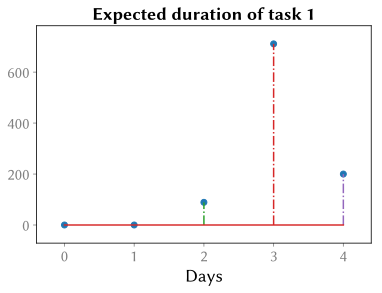

In [4]:
N = 1000
sim = numpy.zeros(N, dtype=int)
for i in range(N):
    sim[i] = task1_days()
plt.stem(numpy.bincount(sim), '-.')
plt.title("Expected duration of task 1", weight="bold")
plt.xlabel("Days")
plt.margins(0.1)

We check that this result is plausible: the most likely duration is three days, and a duration of four days roughly two times more likely than a duration of 2 days. OK, this fits our task description.

We then define similar functions for the duration of tasks 2 and 3.

In [5]:
def task2_days() -> int:
    u = numpy.random.uniform()
    if u < 0.6: return 6
    if u < 0.8: return 5
    return 8

def task3_days() -> int:
    u = numpy.random.uniform()
    if u < 0.8: return 4
    if u < 0.85: return 3
    return 5

We assume that each task is dependent on the task before it, meaning that the three tasks must be executed in sequence. The total duration of the project is simply the sum of the individual task durations. 

Note that in real applications, some tasks will most likely be able to be executed in parallel. Furthermore, the number of tasks will be much greater, and can reach several hundred. The method shown here will still work, though a graphical user interface to describe tasks will be very helpful to users. 

In [6]:
def project_duration() -> int:
    return task1_days() + task2_days() + task3_days()

We can now run a large number of simulations of project execution, and from these estimate the worst case, best case and median durations. We can also provide the expected probability distribution of the duration.

Worst case: 17 days
Best case: 10 days
Median: 13.0 days


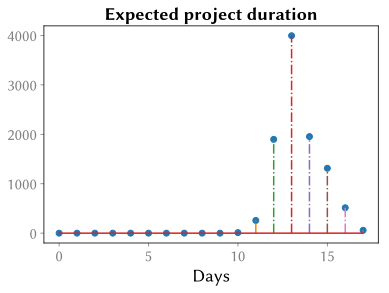

In [7]:
N = 10000
sim = numpy.zeros(N, dtype=int)
for i in range(N):
    sim[i] = project_duration()
plt.stem(numpy.bincount(sim), '-.')
plt.title("Expected project duration", weight='bold')
plt.xlabel("Days");
print("Worst case: {} days".format(sim.max()))
print("Best case: {} days".format(sim.min()))
print("Median: {} days".format(numpy.median(sim)))

We can also provide other quantile measures of estimated project duration. For example, to determine the duration that we are 95% confident will not be exceeded, we calculate the 95th percentile.

In [8]:
numpy.percentile(sim, 95)

16.0

## Parallel tasks

Suppose that tasks 2 and 3 run in parallel, instead of sequentially (one after the other). Their contribution to total project duration is the maximum of the two durations, rather than the sum as previously. We could adjust the code that calculates total project duration as follows: 

In [9]:
def project_duration() -> int:
    return task1_days() + max(task2_days(), task3_days())

## Historical note

The first major use of stochastic simulation techniques for project risk management was the [PERT method](https://en.wikipedia.org/wiki/Program_evaluation_and_review_technique), developed by the US Navy Special Projects Office in the 1950s to help manage the development of Polaris nuclear submarines. The method incorporated uncertainty in project schedule estimates based on inputs provided by subproject leaders. Rather than ask engineers about the variance of their duration estimates (not a very natural feature of human estimates…), the PERT specialists would ask engineers to provide optimistic, most likely and pessimistic estimates of duration, and would fit a beta probability distribution to these parameters. 